# 펀다 상점 매출 Using Facebook Prophet
- 카드거래 취소 적용한 data_pos.csv 사용
- 2019-03-01부터 2019-05-31까지 sales amount의 true값을 모르기 때문에 파라미터 조정이 불가
- 주어진 train data를 새로운 train, test data로 분리함
- train data의 거래일자가 지나치게 sparse한 store_id는 배제
- 마찬가지로 true 값으로 사용할 test data의 거래일자가 지나치게 sparse한 store_id 배제
- true값으로 사용할 test data 처리
    1. 빈 거래일자 3개월치로 보정 (실제 대회 평가용 데이터가 sparse하지 않다고 생각)
    2. 실제 평가용 데이터도 비어있다고 생각
- train data로부터 추정한 3개월 동안의 판매량과 test_data의 판매량 비교 (Mean Absolute Error)
- test data의 기간을 바꿔가며 테스트
- 파라미터 
    - 샘플링 관련
        - sampling_period_days : 14, 28
        - make_future : (periods=6,freq='2W') , (preiods=3, freq='M')
    - 트랜드 관련
        - changepoint_range : 기본 0.8
        - changepoint_prior_scale : 기본 0.05 클수록 그래프 유연성

In [25]:
import numpy as np
import pandas as pd
from pandas import datetime
import matplotlib.pyplot as plt
from fbprophet import Prophet
import warnings
warnings.filterwarnings(action='ignore')
df = pd.read_csv('data_pos.csv')
print("done")

done


#### train data, test data로 분리
- train 2016.6.1 ~ 2018.10.1
- test 2018.10.1 ~ 2019.1.1

In [26]:
test_start = datetime(2018,10,1)
test_end = datetime(2019,1,1)
print("done")

done


In [27]:
df.transacted_date = pd.to_datetime(df.transacted_date)
test_groupby_date_store = df.groupby(['transacted_date', 'store_id'])['amount'].sum()
test_groupby_date_store = test_groupby_date_store.reset_index()
test_groupby_date_store = test_groupby_date_store.set_index('transacted_date')
store_list = test_groupby_date_store.store_id.unique()
store_list.sort()
print("store list :")
print(store_list)


ts_train = test_groupby_date_store[test_groupby_date_store.index<test_start]
ts_test = test_groupby_date_store[test_groupby_date_store.index>=test_start]
ts_test = ts_test[ts_test.index<test_end]

# train test 개수가 적합한지 확인
threshold = (test_start - datetime(2016,6,1)).days
ts_train_number = ts_train.groupby(['store_id']).count()
ts_train_number = ts_train_number[ts_train_number.amount>0.5*threshold]
store_list_train = ts_train_number.index.unique()
threshold2 = (test_end - test_start).days
ts_test_number = ts_test.groupby(['store_id']).count()
ts_test_number = ts_test_number[ts_test_number.amount>0.5*threshold2]
store_list_test = ts_test_number.index.unique()
store_list = [store_id for store_id in store_list_test if store_id in store_list_train]
print("store list size",len(store_list))

# 결과값만 미리 구하자
print(threshold2)
true_sum = {}
for store_id in store_list[:]:
    
    sales = ts_test[ts_test.store_id==store_id].amount
#     true_sum[store_id]=sales.sum()*(threshold2/sales.count()) # 보정
    true_sum[store_id]=sales.sum() # 빈 매출 그대로


print(ts_train)
print("done")

store list :
[   0    1    2 ... 2134 2135 2136]
store list size 1321
92
                 store_id         amount
transacted_date                         
2016-06-01              0   12571.428571
2016-06-01              1    6500.000000
2016-06-01              4   47142.857143
2016-06-01              5   34857.142857
2016-06-01             14  220285.714286
2016-06-01             17    7785.714286
2016-06-01             20  188571.428571
2016-06-01             23   13571.428571
2016-06-01             24   14285.714286
2016-06-01             27   22357.142857
2016-06-01             28  105500.000000
2016-06-01             29   18571.428571
2016-06-01             30   14142.857143
2016-06-01             31   49142.857143
2016-06-01             33    4285.714286
2016-06-01             34   11571.428571
2016-06-01             35   87000.000000
2016-06-01             36  235285.714286
2016-06-01             38   47857.142857
2016-06-01             40   42285.714286
2016-06-01             41

In [20]:
def sampling(input_df, sampling_period_days):
    input_df = input_df[len(input_df) % sampling_period_days:].resample(str(sampling_period_days) + 'D').sum()
    return input_df
print("done")

done


In [ ]:
# make model and predict
stores = df['store_id'].unique()
store_size = 50 # 50개 컷
test_sum = {}
i = 0
for store_id in store_list[:store_size]:
    i += 1
    print(i," ",store_id)
    store_ts = ts_train[ts_train.store_id==store_id]
    store_ts = sampling(store_ts,14)
    count_zero = len(store_ts[(store_ts.amount == 0) | (store_ts.amount.isna())])
    cps = max(0.5*((1 - (count_zero)/len(store_ts))),0.05)
    # prophet 데이터
    store_ts['y'] = store_ts['amount']
    store_ts['ds'] = store_ts.index
    store_ts = store_ts.drop('amount', axis=1)
    store_ts = store_ts.drop('store_id', axis=1) 
    # prediction
    m = Prophet(changepoint_prior_scale=cps,changepoint_range=0.8)
    m_fit = m.fit(store_ts)
    future = m_fit.make_future_dataframe(periods=6,freq='2W')
    forecast = m_fit.predict(future)
    size = store_ts.shape[0]
    result = np.sum(forecast.yhat[size:])
    test_sum[store_id] = result
#     print(forecast[size:])
#     print(forecast.yhat[size:])
    fig1 = m.plot(forecast)
    plt.title("number {} store_id {} cps : {}".format(i,store_id,cps))

#### 결과 후처리

In [31]:
new_true_dict = {}
new_true_dict['store_id'] = []
new_true_dict['amount'] = []
new_test_dict = {}
new_test_dict['store_id'] = []
new_test_dict['amount'] = []
# print(store_list)
for store_id in store_list[:store_size]:
#     print(store_id)
    new_true_dict['amount'].append(true_sum[store_id])
    new_true_dict['store_id'].append(store_id)
    try:
        new_test_dict['amount'].append(test_sum[store_id])
    except:
        print(store_id)
    new_test_dict['store_id'].append(store_id)
true_frame = pd.DataFrame(new_true_dict)   
true_frame =true_frame.set_index("store_id")
predict_frame = pd.DataFrame(new_test_dict)
predict_frame = predict_frame.set_index("store_id")
predict_frame = predict_frame['amount'].apply((lambda x: x*1))
print("done")

done


#### predict sum, true sum plot

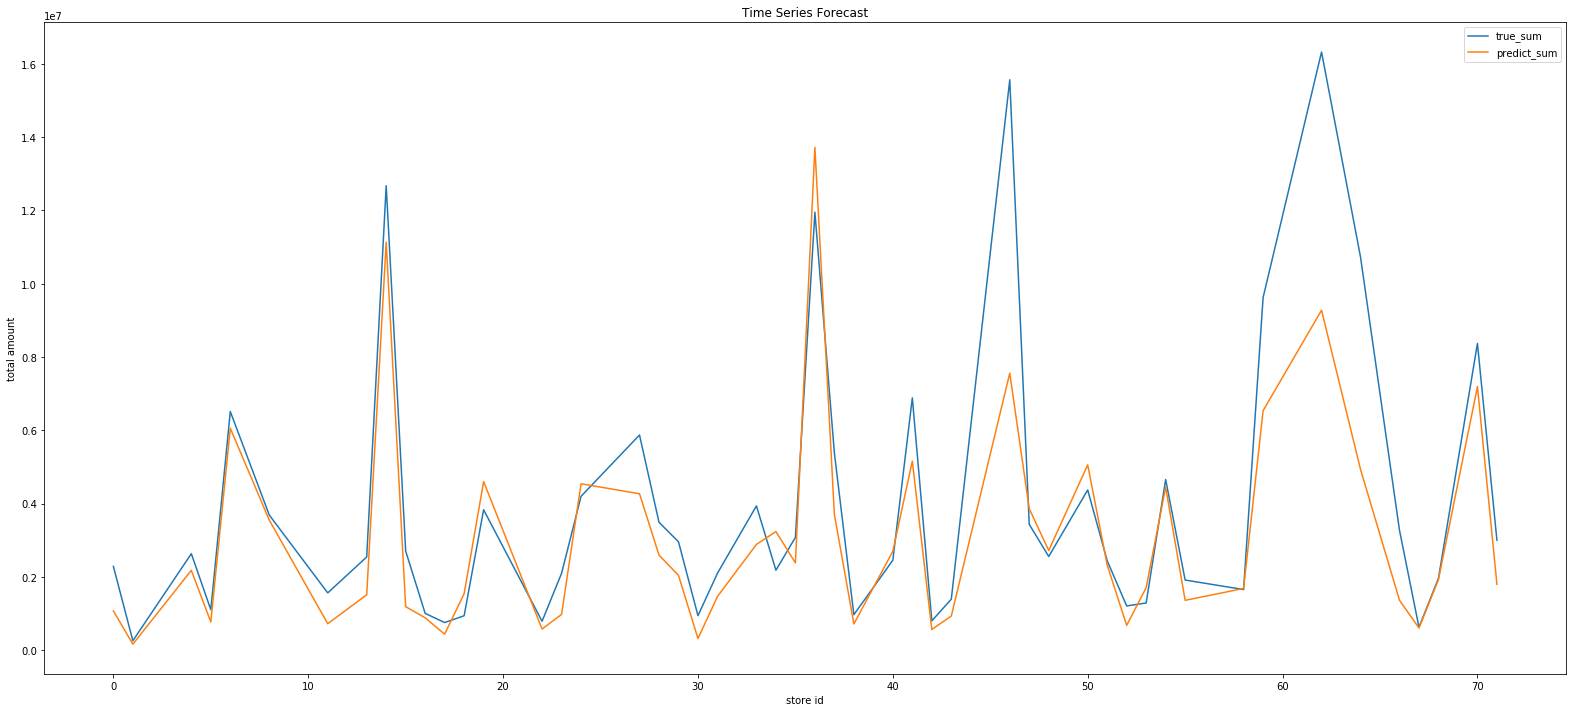

In [32]:
plt.figure(figsize=(22,10))
plt.plot(true_frame,label = "true_sum")
plt.plot(predict_frame,label = "predict_sum")
plt.title("Time Series Forecast")
plt.xlabel("store id")
plt.ylabel("total amount")
plt.legend()
plt.tight_layout()
plt.show()

#### Mean Absoulute Error

In [33]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(predict_frame[:store_size],true_frame[:store_size])
print(mae)

1126833.182078932
